# Advanced Use: High-level DIC + Differentiable Kernels (Uncertainty Propagation)

This notebook shows **two complementary ways** to use the `d2ic` package:

1. **Classic DIC (high-level API)**: build a mesh from `roi.tif`, run a DIC solve, and plot displacement/strain fields.
2. **Differentiation / uncertainty propagation (kernel-level JAX functions)**: reuse the same pixel/mesh assets but call the JAX kernels directly so you can compute Jacobian-vector products (JVPs) w.r.t. the deformed image.

The key idea: DIC is formulated as the minimization of a differentiable objective

$$ u^*(I_2) = \arg\min_u \; J(u; I_1, I_2) = J_{\text{img}}(u; I_1, I_2) + \alpha\,J_{\text{reg}}(u) $$

and the strain is a differentiable post-processing of the displacement field.

We will propagate a simple additive image noise model through the full pipeline using **first-order linearization** (JVP) and compare it with finite differences.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import annotations

import logging
import os
from dataclasses import replace
from pathlib import Path
import sys

import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Silence noisy PJRT plugin init errors on environments without a working CUDA stack.
logging.getLogger('jax._src.xla_bridge').setLevel(logging.CRITICAL)

# CPU by default for reproducibility. Remove this line if you want JAX to pick a GPU when available.
os.environ.setdefault('JAX_PLATFORMS', 'cpu')

jax.config.update('jax_enable_x64', True)
print('JAX devices:', jax.devices())


JAX devices: [CudaDevice(id=0)]


## 1) Load images and ROI

We use the PlateHole example images shipped in `doc/img/PlateHole`.


ref: ohtcfrp_00.tif (1040, 400) float64
def: ohtcfrp_10.tif (1040, 400) float64
mask: (1040, 400) bool roi_pixels= 278049


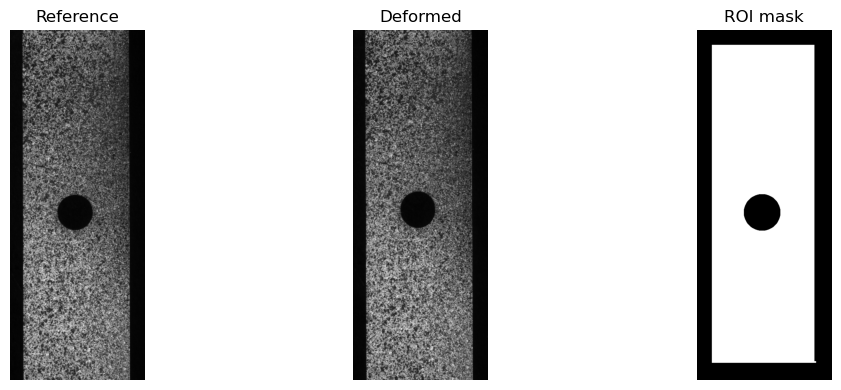

In [2]:
from d2ic import (
    InitMotionConfig,
    MeshDICConfig,
    DICInitMotion,
    DICMeshBased,
    TranslationZNCCSolver,
    GlobalCGSolver,
    LocalGaussNewtonSolver,
    BatchConfig,
    BatchMeshBased,
    mask_to_mesh_assets_gmsh,
    DICPlotter,
    DICResult,
    DICDiagnostics,
)
from d2ic.pixel_assets import build_pixel_assets
from d2ic.strain import compute_green_lagrange_strain_nodes_lsq, green_lagrange_to_voigt

img_dir = Path() / 'img' / 'PlateHole'
out_dir = Path() / '_outputs' / 'advanced_uncertainty'
out_dir.mkdir(parents=True, exist_ok=True)

ref_path = img_dir / 'ohtcfrp_00.tif'
def_path = img_dir / 'ohtcfrp_10.tif'
mask_path = img_dir / 'roi.tif'

im_ref = imread(ref_path).astype(float)
im_def = imread(def_path).astype(float)
mask = imread(mask_path)
if mask.ndim == 3:
    mask = mask[..., 0]
mask = mask > 0

print('ref:', ref_path.name, im_ref.shape, im_ref.dtype)
print('def:', def_path.name, im_def.shape, im_def.dtype)
print('mask:', mask.shape, mask.dtype, 'roi_pixels=', int(mask.sum()))

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap='gray')
ax[0].set_title('Reference')
ax[1].imshow(im_def, cmap='gray')
ax[1].set_title('Deformed')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('ROI mask')
for a in ax:
    a.axis('off')
plt.tight_layout()


## 2) Mesh generation from `roi.tif` (Gmsh)

We generate a quadrilateral mesh with the Gmsh-based pipeline:

- `d2ic.mask2mesh.mask_to_mesh_assets_gmsh`

This returns `(mesh, assets)` where `assets` already contains node-neighborhood tables (needed for strain LSQ).
We then build pixel assets from the reference image, which are required by the global CG solver.


In [3]:
MESH_ELEMENT_SIZE_PX = 15.0  # increase to speed up (fewer nodes), decrease for higher spatial resolution
BINNING = 1

mesh, assets = mask_to_mesh_assets_gmsh(
    mask=mask,
    element_size_px=MESH_ELEMENT_SIZE_PX,
    binning=BINNING,
    contour_step_px=2.0,
    remove_islands=True,
    min_island_area_px=64,
)

pixel_assets = build_pixel_assets(mesh=mesh, ref_image=im_ref, binning=BINNING)
assets = replace(assets, pixel_data=pixel_assets)

print('nodes:', np.asarray(mesh.nodes_xy).shape)
print('elements:', np.asarray(mesh.elements).shape)
print('pixel_coords_ref:', np.asarray(pixel_assets.pixel_coords_ref).shape)



nodes: (3065, 2)
elements: (1499, 4)
pixel_coords_ref: (279029, 2)


## 3) Classic DIC (high-level API)

This is the recommended entry point for everyday DIC usage:

- `DICInitMotion` (optional coarse initialization)
- `DICMeshBased` + `GlobalCGSolver`
- optional local refinement with `LocalGaussNewtonSolver`
- plotting with `DICPlotter`


In [4]:
# Parameters (keep them modest for notebook runtime; increase for production runs)
ENABLE_INIT = True
CG_MAX_ITERS = 150
CG_TOL = 1e-3
REG_STRENGTH = 1e-2
INTERPOLATION = 'cubic'

LOCAL_REFINEMENT_SWEEPS = 0  # set >0 to enable local refinement
LOCAL_LAM = 0.1
LOCAL_REG_STRENGTH = 1.0
LOCAL_MAX_STEP = 0.2
LOCAL_OMEGA = 0.5

init_cfg = InitMotionConfig(win=41, search=24)
mesh_cfg = MeshDICConfig(
    max_iters=CG_MAX_ITERS,
    tol=CG_TOL,
    reg_strength=REG_STRENGTH,
    strain_gauge_length=40.0,
)

# Mesh-based global solve
cg_solver = GlobalCGSolver(interpolation=INTERPOLATION)
dic_mesh = DICMeshBased(mesh=mesh, solver=cg_solver, config=mesh_cfg)
dic_mesh.prepare(im_ref, assets)

# Optional init motion
if ENABLE_INIT:
    dic_init = DICInitMotion(init_cfg, TranslationZNCCSolver(init_cfg))
    dic_init.prepare(im_ref, assets)
    init_res = dic_init.run(im_def)
    dic_mesh.set_initial_guess(init_res.u_nodal)
    print('init mean [px]:', np.asarray(init_res.u_nodal).mean(axis=0))

result_hl = dic_mesh.run(im_def)
print('high-level diagnostics:', result_hl.diagnostics.info)
print('u mean [px]:', np.asarray(result_hl.u_nodal).mean(axis=0))
print('strain shape:', np.asarray(result_hl.strain).shape)


init mean [px]: [-0.72661255 -8.39722894]
high-level diagnostics: {'stage': 'mesh_based', 'n_iters': 150, 'history': 'attached', 'strain': 'green_lagrange'}
u mean [px]: [-0.71175927 -8.40083222]
strain shape: (3065, 3)


In [5]:
# Optional local refinement
if LOCAL_REFINEMENT_SWEEPS > 0:
    local_cfg = MeshDICConfig(
        max_iters=LOCAL_REFINEMENT_SWEEPS,
        tol=CG_TOL,
        reg_strength=LOCAL_REG_STRENGTH,
        strain_gauge_length=40.0,
    )
    local_solver = LocalGaussNewtonSolver(
        lam=LOCAL_LAM,
        max_step=LOCAL_MAX_STEP,
        omega=LOCAL_OMEGA,
        interpolation=INTERPOLATION,
    )
    dic_local = DICMeshBased(mesh=mesh, solver=local_solver, config=local_cfg)
    dic_local.prepare(im_ref, assets)
    dic_local.set_initial_guess(result_hl.u_nodal)
    result_hl = dic_local.run(im_def)
    print('refined u mean [px]:', np.asarray(result_hl.u_nodal).mean(axis=0))


In [6]:
plotter = DICPlotter(result=result_hl, mesh=mesh, def_image=im_def, ref_image=im_ref, project_on_deformed='fast')


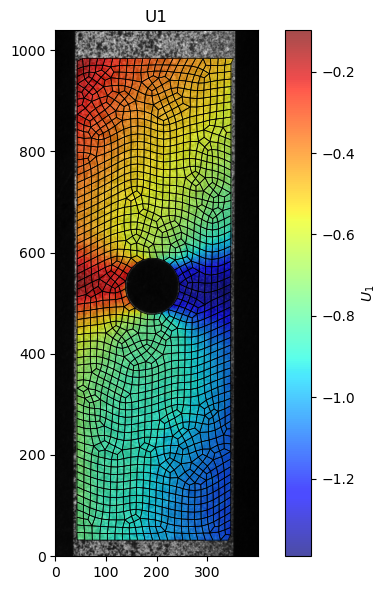

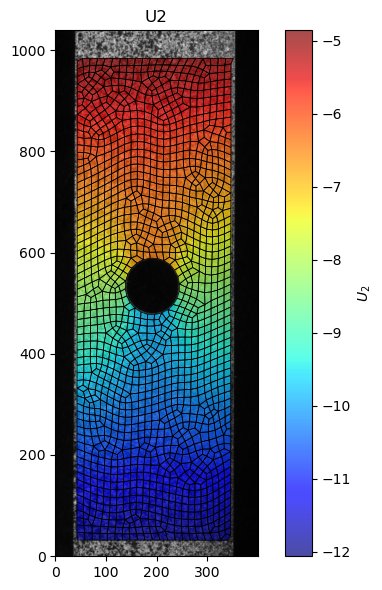

In [7]:

fig, ax = plotter.plot('u1', image_alpha=0.7, plotmesh=True)
ax.set_title('U1')
plt.tight_layout()
plt.show()
fig, ax = plotter.plot('u2', image_alpha=0.7, plotmesh=True)
ax.set_title('U2')
plt.tight_layout()
plt.show()


## 4) Differentiability: what is differentiable, and what to differentiate

The `d2ic` pipeline is built around **JAX kernels** that are differentiable by construction:

### Image mismatch term (differentiable)
- `d2ic/solver_global_cg.py`:
  - `residuals_pixelwise_core(...)` computes per-pixel residuals `r = I2(x+u(x)) - I1(x)`
  - `J_pixelwise_core(...)` computes `0.5 * mean(r^2)`

### Regularization term (differentiable)
- `d2ic/solver_global_cg.py`:
  - `reg_energy_spring_global(...)` implements a spring-like smoothness prior over nodal neighbors

### Full objective (differentiable)
- `d2ic/solver_global_cg.py`:
  - `J_total(...) = J_pixelwise_core + reg_strength * reg_energy_spring_global`
  - `_J_TOTAL_VG = jax.value_and_grad(J_total)` is the gradient used by the CG loop

### Optimizer loop (differentiable in JAX)
- `d2ic/solver_global_cg.py`:
  - `_cg_solve(...)` is implemented with `jax.lax.while_loop`, so JAX can trace it and differentiate through it.

### Strain post-processing (differentiable)
- `d2ic/strain.py`:
  - `compute_green_lagrange_strain_nodes_lsq(...)`
  - `green_lagrange_to_voigt(...)`

In the next section we will build a pure-JAX end-to-end function

$$I_2 \mapsto u^*(I_2) \mapsto E(u^*(I_2))$$

and use `jax.jvp` to propagate image noise to strain uncertainty.


### Two layers, two goals

It helps to separate *what you do in classic DIC* from *what you differentiate*:

**A) Classic DIC (high-level API)**
- You typically call `DICMeshBased.run(I2)` (or `BatchMeshBased.run([...])`) and you treat the solver as a black box.
- You visualize/export fields with `DICPlotter`.

**B) Differentiation / sensitivity / uncertainty (kernel level)**
Depending on your goal, you usually differentiate one of these:

1. **Differentiate the objective** (good to understand the math / implement custom optimizers):
   - Differentiate `J_total(u, I1, I2, ...)` w.r.t. `u` to get `∂J/∂u`.
   - Optionally differentiate again to build Hessian-vector products (HVPs) for Newton/CG variants.

2. **Differentiate the full solution map** (useful for uncertainty propagation):
   - Define a pure function `I2 ↦ u*(I2)` by calling the solver kernel (e.g. `_cg_solve`).
   - Chain it with post-processing `u ↦ E(u)` and use `jax.jvp` / `jax.vjp`.

Both approaches rely on the same differentiable building blocks (image sampling + residuals + regularization + strain LSQ).


## 5) Kernel-level end-to-end function (for JVP / uncertainty propagation)

Here we call the JAX kernels directly. This is the pattern you want when you need derivatives:

- keep the **same assets** (mesh + pixel caches),
- write a **pure function** that calls the solver kernel and then the strain kernel,
- apply `jax.jvp` or `jax.vjp` to propagate perturbations.


In [8]:
from d2ic.solver_global_cg import J_total, _cg_solve

# Pack the fixed inputs for the kernel path
pix = assets.pixel_data
assert pix is not None

im1 = jnp.asarray(im_ref)
im1_T = jnp.transpose(im1, (1, 0))

pixel_coords_ref = jnp.asarray(pix.pixel_coords_ref)
pixel_nodes = jnp.asarray(pix.pixel_nodes)
pixel_shapeN = jnp.asarray(pix.pixel_shapeN)

node_neighbor_index = jnp.asarray(pix.node_neighbor_index)
node_neighbor_degree = jnp.asarray(pix.node_neighbor_degree)
node_neighbor_weight = jnp.asarray(pix.node_neighbor_weight)
node_reg_weight = jnp.asarray(pix.node_reg_weight)

reg_strength = float(REG_STRENGTH)

# Use the high-level result as a warm-start (optional)
disp0 = jnp.asarray(result_hl.u_nodal)

# IMPORTANT for differentiation:
# The CG kernel has an early-stop condition `||grad|| < tol`. If `disp0` is already
# near the optimum for `im2_ref`, the solver may stop at iteration 0, making the
# traced function locally *constant* w.r.t. `im2` -> JVP becomes exactly zero.
#
# For sensitivity / uncertainty propagation, we therefore *disable early stopping*
# and run a fixed number of iterations.
MAX_ITERS_DERIV = 25
TOL_DERIV = -1.0  # ensures `||grad|| < tol` is always False

@jax.jit
def solve_u(im2: jnp.ndarray) -> jnp.ndarray:
    im2_T = jnp.transpose(im2, (1, 0))
    disp_sol, _hist, n_iter = _cg_solve(
        disp0,
        im1_T,
        im2_T,
        pixel_coords_ref,
        pixel_nodes,
        pixel_shapeN,
        node_neighbor_index,
        node_neighbor_degree,
        node_neighbor_weight,
        node_reg_weight,
        reg_strength,
        int(MAX_ITERS_DERIV),
        float(TOL_DERIV),
        INTERPOLATION,
        False,
        log_cg=False,
    )
    # n_iter is returned for diagnostics (ignored by the JVP path)
    return disp_sol

@jax.jit
def strain_voigt_from_u(u_nodal: jnp.ndarray) -> jnp.ndarray:
    _F_all, E_all = compute_green_lagrange_strain_nodes_lsq(
        displacement=u_nodal,
        nodes_coord=jnp.asarray(mesh.nodes_xy),
        node_neighbor_index=jnp.asarray(assets.node_neighbor_index),
        node_neighbor_degree=jnp.asarray(assets.node_neighbor_degree),
        gauge_length=float(mesh_cfg.strain_gauge_length),
        eps=float(mesh_cfg.strain_eps),
    )
    return green_lagrange_to_voigt(E_all)

@jax.jit
def end_to_end_strain(im2: jnp.ndarray) -> jnp.ndarray:
    u = solve_u(im2)
    e_voigt = strain_voigt_from_u(u)  # (Nnodes, 3) with columns [E11, E22, E12]
    return e_voigt

# Reference values for later comparisons
im2_ref = jnp.asarray(im_def)

# Diagnostic: check how many iterations would be taken with the *classic* tolerance.
# (Not used for differentiation.)
_, _hist_tol, n_iter_tol = _cg_solve(
    disp0,
    im1_T,
    jnp.transpose(im2_ref, (1, 0)),
    pixel_coords_ref,
    pixel_nodes,
    pixel_shapeN,
    node_neighbor_index,
    node_neighbor_degree,
    node_neighbor_weight,
    node_reg_weight,
    reg_strength,
    int(CG_MAX_ITERS),
    float(CG_TOL),
    INTERPOLATION,
    False,
    log_cg=True,
)
print('CG iterations with CG_TOL:', int(n_iter_tol))
print('CG iterations used for derivatives:', int(MAX_ITERS_DERIV))

E_ref = end_to_end_strain(im2_ref)
print('E_ref:', E_ref.shape, E_ref.dtype)


CG iterations with CG_TOL: 17
CG iterations used for derivatives: 25
E_ref: (3065, 3) float64


## 6) Sanity check: high-level API vs kernel path

The goal is not perfect bitwise equality. In particular, the *kernel path* used for derivatives runs a **fixed**
number of CG iterations (and disables early stopping) to avoid a zero-JVP artifact at convergence.

So you should expect some differences between the two fields unless you increase `MAX_ITERS_DERIV`.


In [9]:
u_kernel = np.asarray(solve_u(im2_ref))
E_kernel = np.asarray(E_ref)

u_hl = np.asarray(result_hl.u_nodal)
E_hl = np.asarray(result_hl.strain)

print('||u_kernel - u_highlevel|| / ||u_highlevel|| =', np.linalg.norm(u_kernel - u_hl) / (np.linalg.norm(u_hl) + 1e-12))
print('||E_kernel - E_highlevel|| / ||E_highlevel|| =', np.linalg.norm(E_kernel - E_hl) / (np.linalg.norm(E_hl) + 1e-12))


||u_kernel - u_highlevel|| / ||u_highlevel|| = 5.5731161886102504e-05
||E_kernel - E_highlevel|| / ||E_highlevel|| = 0.005670696412722899


## 7) Example derivatives: gradient of the objective w.r.t. the displacement

At the optimum, the gradient `∂J/∂u` should be small (up to solver tolerances).
This is also a good way to understand *what* the solver is minimizing.


In [10]:
im2_T = jnp.transpose(im2_ref, (1, 0))

J_val = J_total(
    jnp.asarray(u_kernel),
    im1_T,
    im2_T,
    pixel_coords_ref,
    pixel_nodes,
    pixel_shapeN,
    node_neighbor_index,
    node_neighbor_degree,
    node_neighbor_weight,
    node_reg_weight,
    INTERPOLATION,
    reg_strength,
)

grad_u = jax.grad(J_total)(
    jnp.asarray(u_kernel),
    im1_T,
    im2_T,
    pixel_coords_ref,
    pixel_nodes,
    pixel_shapeN,
    node_neighbor_index,
    node_neighbor_degree,
    node_neighbor_weight,
    node_reg_weight,
    INTERPOLATION,
    reg_strength,
)

print('J(u):', float(J_val))
print('||grad_u||:', float(jnp.linalg.norm(grad_u)))
print('grad_u mean:', np.asarray(grad_u).mean(axis=0))


J(u): 4.937059434264626
||grad_u||: 0.000871242342146053
grad_u mean: [2.71569513e-07 4.70259335e-07]


## 8) Image noise model

We use additive Gaussian noise on the deformed image: `I2_noisy = I2 + δI`, with `δI ~ N(0, σ_I^2)`.


In [11]:
sigma_I = 2.0  # grayscale levels (for 8-bit images, typical values are 1..5)
rng_key = random.PRNGKey(0)


def sample_image_noise(key, sigma=sigma_I):
    return sigma * random.normal(key, shape=im2_ref.shape, dtype=im2_ref.dtype)

rng_key, preview_key = random.split(rng_key)
delta_preview = sample_image_noise(preview_key)
print('noise mean: ', float(jnp.mean(delta_preview))," std:", float(jnp.std(delta_preview)))


noise mean:  -0.00042796389377451404  std: 2.0016339032790693


## 9) First-order propagation with JVP

We want the **sensitivity** of the strain field with respect to the deformed image intensity values.
Formally, for the end-to-end mapping

$$ E : I_2 \mapsto E(I_2), $$

the first-order variation reads

$$ \delta E \approx \frac{\partial E(I_2)}{\partial I_2}\,\delta I_2. $$

In practice, we do **not** build the full Jacobian $\partial E/\partial I_2$ (it would be enormous).
Instead, we use a **Jacobian–vector product (JVP)** to evaluate the action of this derivative on a given perturbation $\delta I_2$:

$$ 
\mathrm{JVP}_{I_2}(E(I_2)),[\delta I_2] = \left( \frac{\partial E(I_2)}{\partial I_2}
\right),\delta I_2. 
$$


In [12]:
rng_key, jvp_key = random.split(rng_key)
delta_I2 = sample_image_noise(jvp_key)

_, delta_E = jax.jvp(end_to_end_strain, (im2_ref,), (delta_I2,))  # (Nnodes, 3)

delta_E_np = np.asarray(delta_E)
for name, comp in zip(['dE11', 'dE22', 'dE12'], range(3)):
    vals = delta_E_np[:, comp]
    print(f'{name}: mean={vals.mean():.3e}, std={vals.std():.3e}, max|.|={np.max(np.abs(vals)):.3e}')


dE11: mean=-5.591e-06, std=2.591e-04, max|.|=2.669e-03
dE22: mean=-2.828e-06, std=2.327e-04, max|.|=2.376e-03
dE12: mean=-2.166e-06, std=1.733e-04, max|.|=1.635e-03


## 10) Monte Carlo estimate of strain standard deviations (using JVP)

For Gaussian noise, the JVP gives a fast way to approximate per-node standard deviations without re-solving the full optimization many times.


In [13]:
n_mc = 12
mc_keys = random.split(rng_key, n_mc + 1)
rng_key = mc_keys[-1]
mc_keys = mc_keys[:-1]

samples = []
for i, key in enumerate(mc_keys, start=1):
    delta = sample_image_noise(key)
    _, dE = jax.jvp(end_to_end_strain, (im2_ref,), (delta,))
    samples.append(dE)
    if i % 6 == 0:
        print(f'Completed {i}/{n_mc} JVP evaluations')

samples = jnp.stack(samples, axis=0)  # (n_mc, Nnodes, 3)
std_E = jnp.sqrt(jnp.mean(samples ** 2, axis=0))  # (Nnodes, 3)
std_E_np = np.asarray(std_E)

for name, comp in zip(['dE11', 'dE22', 'dE12'], range(3)):
    vals = std_E_np[:, comp]
    print(f'{name}: mean std={vals.mean():.3e}, max std={np.max(vals):.3e}')


Completed 6/12 JVP evaluations
Completed 12/12 JVP evaluations
dE11: mean std=1.673e-04, max std=1.558e-03
dE22: mean std=1.438e-04, max std=1.402e-03
dE12: mean std=1.138e-04, max std=8.858e-04


## 11) Visualize strain and uncertainty fields

We reuse `DICPlotter` by building a `DICResult` object.


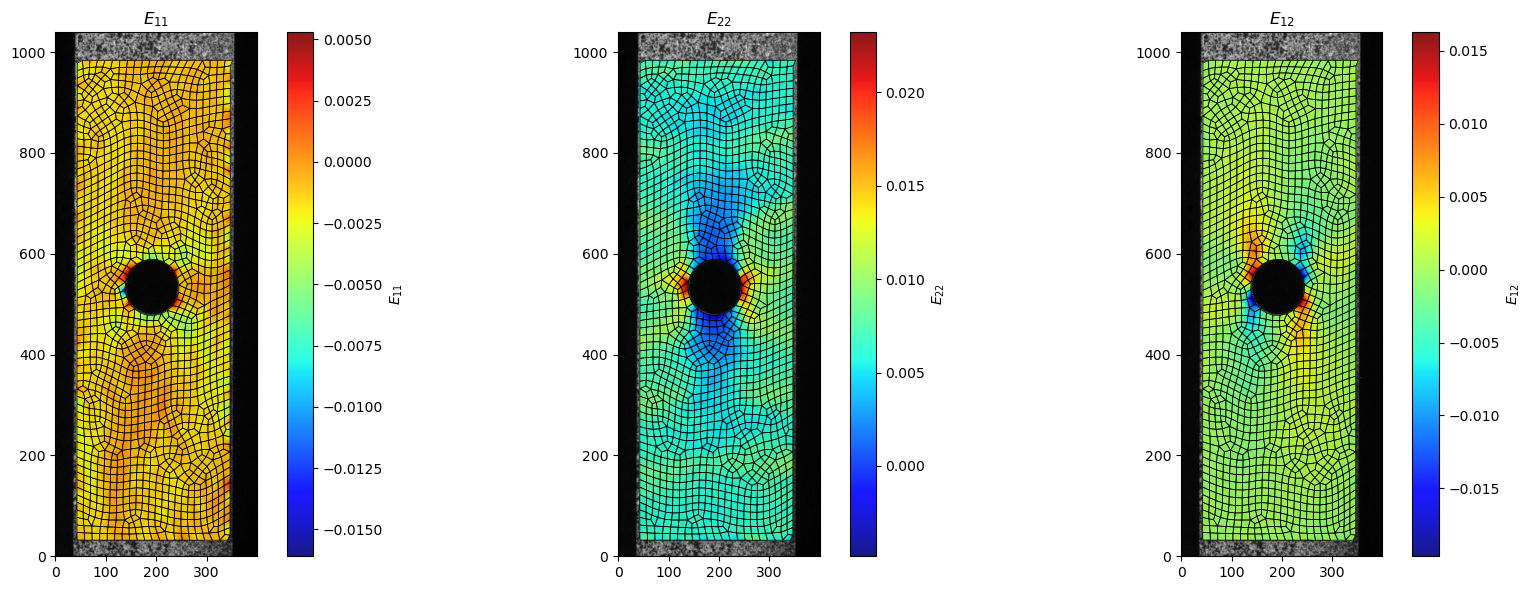

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for field, ax in zip(["E11", "E22", "E12"], axs):
    plotter.plot_into(ax, field, image_alpha=0.9, plotmesh=True)
plt.tight_layout()
plt.savefig(out_dir / 'strain_fields.png', dpi=300)
plt.show()

In [15]:
# Plot a log-scaled uncertainty map without relying on Matplotlib log Colorbar plumbing.
# We plot log10(sigma) (values in decades) and relabel ticks as 1e-4, 1e-3, ...

std_eps = 1e-12
std_E_clipped = np.maximum(std_E_np, std_eps)
std_log10 = np.log10(std_E_clipped)

# Store the uncertainty fields as user-defined nodal scalars.
result_std = DICResult(
    u_nodal=jnp.asarray(u_kernel),
    strain=jnp.asarray(E_kernel),
    diagnostics=DICDiagnostics(info={'source': 'jvp_std_log10'}),
    fields={
        'sigma_e11': jnp.asarray(std_log10[:, 0]),
        'sigma_e22': jnp.asarray(std_log10[:, 1]),
        'sigma_e12': jnp.asarray(std_log10[:, 2]),
    },
)
plotter_std = DICPlotter(result=result_std, mesh=mesh, def_image=im_def, ref_image=im_ref, project_on_deformed='fast')

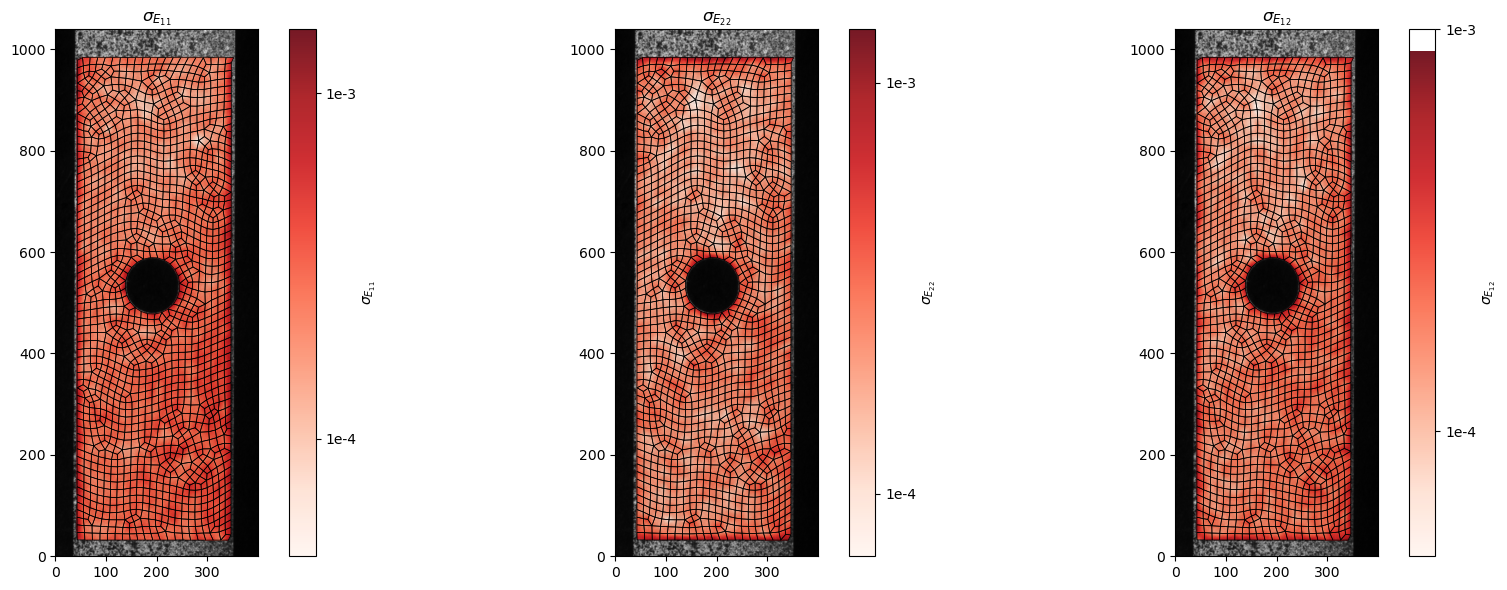

In [16]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for field, ax in zip([r'$\sigma_{E_{11}}$', r'$\sigma_{E_{22}}$', r'$\sigma_{E_{12}}$'], axs):
    _,cbar = plotter_std.plot_into(ax, field, image_alpha=0.9, plotmesh=True, cmap='Reds', add_colorbar=True)
    # Access the Colorbar created by DICPlotter.
    if cbar is not None:
        vmax = float(np.max(std_log10))
        cbar.set_ticks([-4, -3])
        cbar.set_ticklabels(['1e-4', '1e-3'])
plt.tight_layout()
plt.savefig(out_dir / 'strain_uncertainty_log10.png', dpi=300)
plt.show()


## 12) Validation with finite differences

We validate the JVP linearization against a finite-difference approximation:

$$ \frac{E(I_2 + h\,\delta I_2) - E(I_2)}{h} $$

For small enough `h`, this should match the JVP result.


In [18]:
rng_key, val_key = random.split(rng_key)
delta = sample_image_noise(val_key)

_, dE_jvp = jax.jvp(end_to_end_strain, (im2_ref,), (delta,))

h = 1e-3
E_fd = (end_to_end_strain(im2_ref + h * delta) - E_ref) / h

num = jnp.linalg.norm(dE_jvp - E_fd)
den = jnp.linalg.norm(E_fd) + 1e-12
print('Relative error ||JVP-FD||/||FD|| =', float(num / den))
print('Max abs diff =', float(jnp.max(jnp.abs(dE_jvp - E_fd))))


Relative error ||JVP-FD||/||FD|| = 0.00032309040990116634
Max abs diff = 8.318413473753673e-07


## 13) Takeaways

- Use the **high-level API** (`DICMeshBased`, `BatchMeshBased`, `DICPlotter`) for standard DIC workflows.
- For **differentiation**, target the JAX kernels in:
  - `d2ic/solver_global_cg.py` (`J_total`, `_cg_solve`, `residuals_pixelwise_core`, `reg_energy_spring_global`)
  - `d2ic/solver_local_gn.py` if you need derivatives through local refinement
  - `d2ic/strain.py` for strain post-processing
- Uncertainty propagation via `jax.jvp` lets you estimate the sensitivity of strain to image noise with *far fewer* full solves.
